In [1]:
%matplotlib inline
import torch as tc
import tensorflow as tf
import mxnet as mx
from mxnet import np as mxnp
from mxnet import npx as npx
npx.set_np()
# import numpy as np

from d2l import mxnet as mxd2l  # Use MXNet as the backend
from d2l import torch as tcd2l  # Use PyTorch as the backend
from d2l import tensorflow as tfd2l  # Use TensorFlow as the backend

tc.__version__,tf.__version__,mx.__version__

('1.6.0', '2.3.1', '1.7.0')

## mx

In [2]:
from mxnet.gluon import nn
def nin_block(num_channels,kernel_size,strides,padding,with_maxpool2d=True):
    net=nn.Sequential()
    net.add(nn.Conv2D(channels=num_channels,kernel_size=kernel_size,strides=strides,padding=padding,activation='relu'))
    net.add(nn.Conv2D(channels=num_channels,kernel_size=1,activation='relu'))
    net.add(nn.Conv2D(channels=num_channels,kernel_size=1,activation='relu'))
    if with_maxpool2d:
        net.add(nn.MaxPool2D(pool_size=3, strides=2))
    return net    

In [3]:
net=nin_block(96,11,4,0)

In [4]:
X = mxnp.random.uniform(size=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1, 96, 54, 54)
conv1 output shape:	 (1, 96, 54, 54)
conv2 output shape:	 (1, 96, 54, 54)
pool0 output shape:	 (1, 96, 26, 26)


In [5]:
net=nin_block(96,11,4,0,False)
X = mxnp.random.uniform(size=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv3 output shape:	 (1, 96, 54, 54)
conv4 output shape:	 (1, 96, 54, 54)
conv5 output shape:	 (1, 96, 54, 54)


In [6]:
net

Sequential(
  (0): Conv2D(1 -> 96, kernel_size=(11, 11), stride=(4, 4), Activation(relu))
  (1): Conv2D(96 -> 96, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
  (2): Conv2D(96 -> 96, kernel_size=(1, 1), stride=(1, 1), Activation(relu))
)

In [7]:
def nin_mx():
    net=nn.Sequential()
    net.add(
        nin_block(num_channels=96,kernel_size=11,strides=4,padding=0,with_maxpool2d=True),
        nin_block(num_channels=256,kernel_size=5,strides=1,padding=2,with_maxpool2d=True),
        nin_block(num_channels=384,kernel_size=3,strides=1,padding=1,with_maxpool2d=True),
        nn.Dropout(0.5),
        nin_block(num_channels=10,kernel_size=3,strides=1,padding=1,with_maxpool2d=False),
        nn.GlobalAvgPool2D(),
        nn.Flatten()        
    )
    return net

In [8]:
net=nin_mx()

In [9]:
X = mxnp.random.uniform(size=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

sequential3 output shape:	 (1, 96, 26, 26)
sequential4 output shape:	 (1, 256, 12, 12)
sequential5 output shape:	 (1, 384, 5, 5)
dropout0 output shape:	 (1, 384, 5, 5)
sequential6 output shape:	 (1, 10, 5, 5)
pool4 output shape:	 (1, 10, 1, 1)
flatten0 output shape:	 (1, 10)


# torch

In [10]:
from torch import nn
def nin_block_tc(num_in_channels,num_channels,kernel_size,strides,padding,with_maxpool2d=True):
    layers=[nn.Conv2d(in_channels=num_in_channels,out_channels=num_channels,kernel_size=kernel_size,stride=strides,padding=padding),nn.ReLU(),
            nn.Conv2d(in_channels=num_channels,out_channels=num_channels,kernel_size=1),nn.ReLU(),
            nn.Conv2d(in_channels=num_channels,out_channels=num_channels,kernel_size=1),nn.ReLU(),]
    if with_maxpool2d:
        layers.append(nn.MaxPool2d(kernel_size=3, stride=2))
    return nn.Sequential(*layers)    

In [11]:
net=nin_block_tc(1,96,11,4,0,with_maxpool2d=True)

In [12]:
X = tc.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])


In [13]:
net

Sequential(
  (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
  (1): ReLU()
  (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [14]:
net = nn.Sequential(
    nin_block_tc(1, 96, kernel_size=11, strides=4, padding=0),
    nin_block_tc(96, 256, kernel_size=5, strides=1, padding=2),
    nin_block_tc(256, 384, kernel_size=3, strides=1, padding=1),
    nn.Dropout(0.5),
    # There are 10 label classes
    nin_block_tc(384, 10, kernel_size=3, strides=1, padding=1,with_maxpool2d=False),
    nn.AdaptiveAvgPool2d((1, 1)),
    # Transform the four-dimensional output into two-dimensional output with a
    # shape of (batch size, 10)
    nn.Flatten())

In [15]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, st

In [16]:
X = tc.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## tf

In [2]:
def nin_block_tf(num_out_channels,kernel_size,strides,padding,with_maxpool2d=True):
    net=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=num_out_channels,kernel_size=kernel_size,strides=strides,padding=padding,activation='relu'),
        tf.keras.layers.Conv2D(filters=num_out_channels,kernel_size=1,activation='relu'),
        tf.keras.layers.Conv2D(filters=num_out_channels,kernel_size=1,activation='relu')])
    if with_maxpool2d:
        net.add(tf.keras.layers.MaxPooling2D(pool_size=3,strides=2))
    
    return net 

def nin_net_tf():
    net=tf.keras.models.Sequential()
    net.add(nin_block_tf(96,11,4,'valid'))
    net.add(nin_block_tf(256,5,1,'same'))
    net.add(nin_block_tf(384,3,1,'same'))
    net.add(tf.keras.layers.Dropout(0.5))
    net.add(nin_block_tf(10,3,1,'same',with_maxpool2d=False))
    net.add(tf.keras.layers.GlobalAveragePooling2D())
    net.add(tf.keras.layers.Reshape((1,1,10)))
    net.add(tf.keras.layers.Flatten())
    return net

In [4]:
X = tf.random.uniform((1, 224, 224, 1))

In [5]:
b=nin_block_tf(96,11,4,'valid')
net_tf=nin_net_tf()

In [6]:
for layer in b.layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2D output shape:	 (1, 54, 54, 96)
Conv2D output shape:	 (1, 54, 54, 96)
Conv2D output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)


In [ ]:
for layer in b.layers:
    X = net_tf(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

In [8]:
net_tf.layers

In [7]:
net_tf.build((1, 224, 224, 1))

In [8]:
net_tf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (1, 26, 26, 96)           30336     
_________________________________________________________________
sequential_3 (Sequential)    (1, 12, 12, 256)          746240    
_________________________________________________________________
sequential_4 (Sequential)    (1, 5, 5, 384)            1180800   
_________________________________________________________________
dropout (Dropout)            (1, 5, 5, 384)            0         
_________________________________________________________________
sequential_5 (Sequential)    (1, 5, 5, 10)             34790     
_________________________________________________________________
global_average_pooling2d (Gl (1, 10)                   0         
_________________________________________________________________
reshape (Reshape)            (1, 1, 1, 10)            

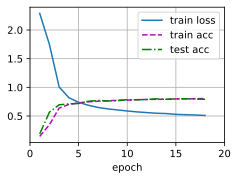

In [ ]:
lr, num_epochs, batch_size = 0.05, 20, 128
train_iter, test_iter = tfd2l.load_data_fashion_mnist(batch_size, resize=224)
tfd2l.train_ch6(nin_net_tf, train_iter, test_iter, num_epochs, lr)